# **Machine Learning Techniques Project**


*   Nicolas Bedoya Figueroa
*   Daniel Escalante Perez
*   Marilyn Stephany Joven Fonseca
*   Eder Leandro Carbonero Baquero

In [1]:
!pip install nltk pyspellchecker tqdm emoji nlpaug transformers tensorflow xgboost[gpu] accelerate

zsh:1: no matches found: xgboost[gpu]


In [2]:
!pip install seaborn transformers torch tqdm umap-learn plotly

Defaulting to user installation because normal site-packages is not writeable


### **Marilyn Stephany Joven Fonseca**

#### GRU

In [3]:
import ast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
df = pd.read_csv("data/embeddings_data.csv")
df.head(5)

,class,tweet,embedding_cls,embedding_mean
0,0,woman complain cleaning house amp man always t...,"[0.03051237016916275, 0.10076580196619034, -0....","[0.06461837887763977, 0.04184044152498245, -0...."
1,1,boy days cold toga bad coffin hoe st place,"[0.016444426029920578, 0.12408909201622009, -0...","[0.018618328496813774, 0.038100823760032654, -..."
2,1,dawn ever fuck bitch start cry confused shit,"[0.04806799441576004, 0.08932863920927048, -0....","[0.17897993326187134, 0.003424710826948285, -0..."
3,1,look like granny,"[-0.013384401798248291, 0.10282494872808456, 0...","[0.05222192779183388, 0.08013958483934402, 0.1..."
4,1,shit hear might true might faker bitch told ya,"[-0.036173366010189056, 0.05091825872659683, -...","[-0.060997892171144485, -0.04308371618390083, ..."


In [5]:
model_name = 'cardiffnlp/twitter-roberta-base'
max_len = 64

tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)
model_roberta.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [6]:

raw_embeddings = df['embedding_cls'].copy()

def safe_parse(x):
    try:
        return ast.literal_eval(x)
    except:
        return None

parsed_embeddings = raw_embeddings.apply(safe_parse)
valid_mask = parsed_embeddings.notnull()
X_seq = parsed_embeddings[valid_mask].tolist()
y = df.loc[valid_mask, 'class'].values

X_seq = [list(map(float, x)) for x in X_seq if isinstance(x, (list, np.ndarray))]

X_array = np.array(X_seq)  

X_ready = X_array.reshape(-1, 1, X_array.shape[1])

In [7]:
X_array = np.array(X_seq)  
X_train, X_test, y_train, y_test = train_test_split(
    X_array, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
## GRU
model = Sequential([
    Input(shape=(X_ready.shape[1], X_ready.shape[2])),  
    GRU(64),  
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [9]:
## DENSE
model = Sequential([
    Input(shape=(768,)),        
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.7903 - loss: 0.4472 - val_accuracy: 0.8493 - val_loss: 0.3415
Epoch 2/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.8515 - loss: 0.3459 - val_accuracy: 0.8543 - val_loss: 0.3308
Epoch 3/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.8553 - loss: 0.3352 - val_accuracy: 0.8555 - val_loss: 0.3304
Epoch 4/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.8604 - loss: 0.3264 - val_accuracy: 0.8564 - val_loss: 0.3242
Epoch 5/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.8609 - loss: 0.3232 - val_accuracy: 0.8568 - val_loss: 0.3223
Epoch 6/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.8599 - loss: 0.3222 - val_accuracy: 0.8584 - val_loss: 0.3196
Epoch 7/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.8655 - loss: 0.3163 - val_accuracy: 0.8579 - val_loss: 0.3200
Epoch 8/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 

In [11]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4672
           1       0.91      0.82      0.86      4869

    accuracy                           0.87      9541
   macro avg       0.87      0.87      0.87      9541
weighted avg       0.87      0.87      0.87      9541

[[4294  378]
 [ 889 3980]]


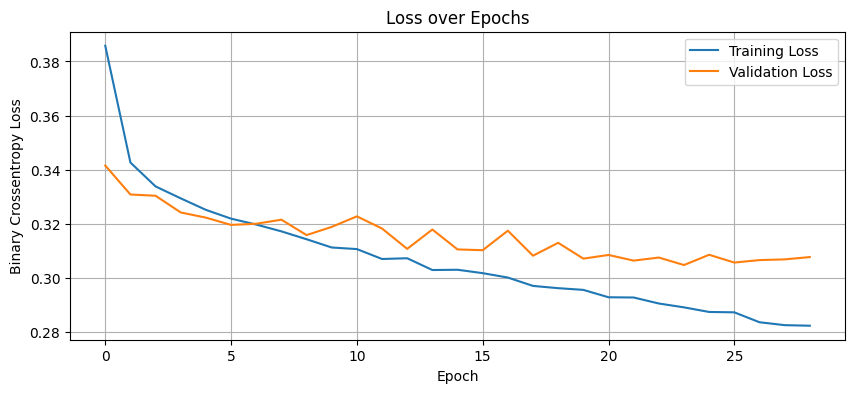

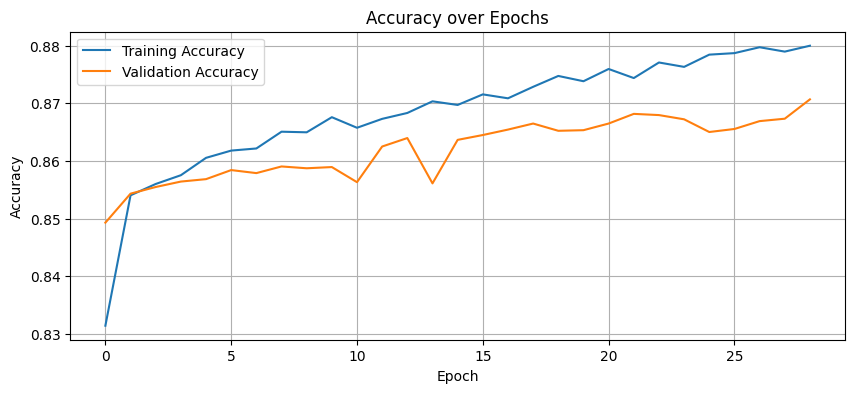

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


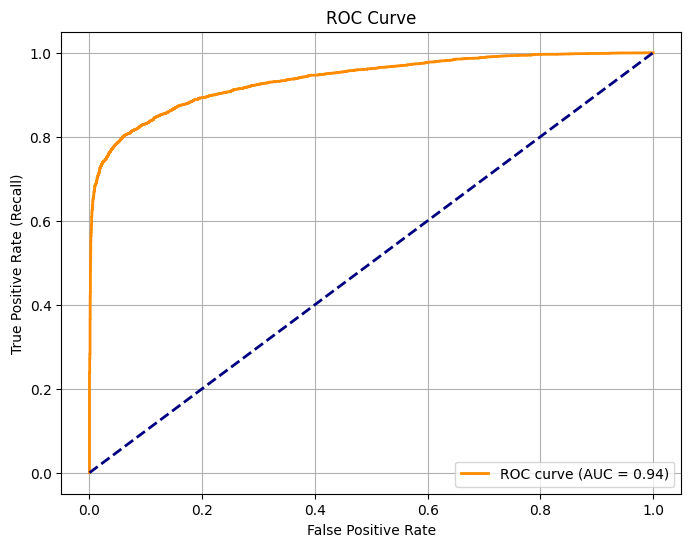

In [13]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


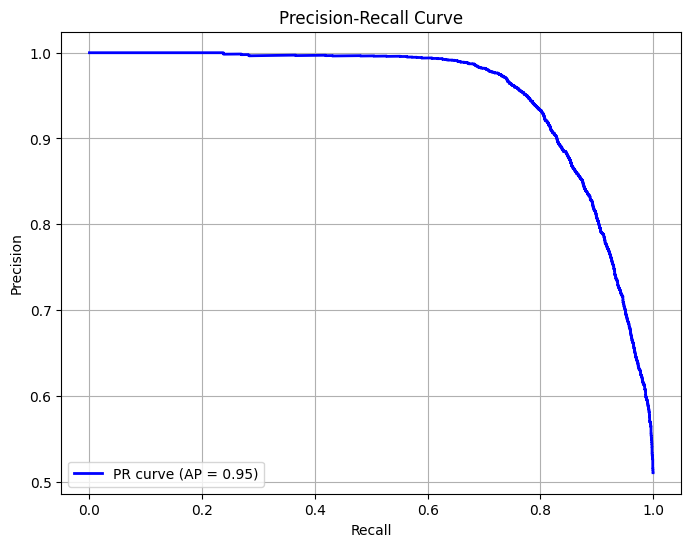

In [14]:

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
pr_auc = average_precision_score(y_test, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [15]:

best_f1 = 0
best_thresh = 0.5

for t in np.arange(0.1, 0.9, 0.01):
    preds = (y_pred_probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best F1: {best_f1:.4f} at threshold {best_thresh:.2f}")


Best F1: 0.8640 at threshold 0.43


In [16]:
def mean_pooling(outputs, attention_mask):
    token_embeddings = outputs.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = input_mask_expanded.sum(1)
    return sum_embeddings / sum_mask


def generate_embeddings(texts, model, tokenizer, max_len=64, device=None):
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    embeddings_cls = []
    embeddings_mean = []

    for text in tqdm(texts, desc='Generando embeddings'):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=max_len)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)

        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        embeddings_cls.append(cls_embedding)

        mean_embedding = mean_pooling(outputs, inputs['attention_mask']).squeeze().cpu().numpy()
        embeddings_mean.append(mean_embedding)

    return embeddings_cls, embeddings_mean

In [17]:
user_texts = [
    "You immigrants take our jobs",     
    "That's really stupid",             
    "I could hate and love you...",     
    "bitches trusted"                   
]

for txt in user_texts:
    emb = generate_embeddings([txt], model_roberta, tokenizer_roberta, max_len)[0][0]
    emb = np.array(emb).reshape(1, -1)  # ✅ shape: (1, 768)
    prob = model.predict(emb)[0][0]
    label = int(prob > 0.34)            # use tuned threshold
    print(f"{txt[:40]}... → {'🚨 HATE' if label == 1 else '✅ NOT HATE'} ({prob:.2f})")

Generando embeddings: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


You immigrants take our jobs... → 🚨 HATE (0.36)


Generando embeddings: 100%|██████████| 1/1 [00:00<00:00, 32.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


That's really stupid... → ✅ NOT HATE (0.30)


Generando embeddings: 100%|██████████| 1/1 [00:00<00:00, 34.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


I could hate and love you...... → ✅ NOT HATE (0.24)


Generando embeddings: 100%|██████████| 1/1 [00:00<00:00, 29.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
bitches trusted... → 🚨 HATE (1.00)
